### Imports

In [1]:
import numpy as np
from scipy.interpolate import CubicSpline, interp1d, make_interp_spline
from scipy.optimize import newton, fsolve
import matplotlib.pyplot as plt
import bond_pricing as bp
# from sympy import *

### Generalized Bootstrap Method to Determine the Yield Curve

#### Model Introduction

If an analyst were able to possess a sufficient quantity of reliable friction-free government bond data, a technique known as the bootstrap would straightforwardly derive the spot yield curve. This technique is based on the notion that individual coupon-paying bonds can be viewed as “packages” of pure discount bonds. For example, a three-year bond is comprised of six pure discount bonds, namely the five coupon payments to be paid every six months, and the final payment which is the sum of the final coupon and the return of principal. This suggests that a bond’s value can be viewed as either the present value of future cash flows discounted at the yield to maturity, or as the sum of the values of individual pure discount bonds, each of which is a present value of a cash flow discounted at its own time-specific yield.

The classic “textbook” explication of the bootstrap usually begins by assuming the existence of a set of perfectly spaced bonds: for example, a 6-month, a 12-month, an 18-month and so on. If these bonds have frictionless market prices, the bootstrap renders the correct yield curve in a straightforward fashion, as will be illustrated below.

The problem with the bootstrap is that it relies heavily on the existence of a suitable body of data. In particular there are two problems: **illiquidity** and **missing data points**. Quotes coming from a thin market may be at divergence from true market prices due to spreads and asynchronous trading. This is why applying the bootstrap to a raw sample of bonds is likely to lead to an unreasonably “choppy” yield curve. One approach is to perform some form of curve fitting to arrive at a reasonably smooth representation of the yield curve. This can be done either before or after utilizing the bootstrap. Nevertheless there is a problem with any smoothing procedure which is unavoidable: the final curve will always be a function of an assumed functional form. For example, the Nelson and Siegel procedure allows for a single hump while the Svensson approach allows for two humps.

There is another approach for eliminating inappropriate shapes, namely to make use of **averaged yield data**. For example, one could take all bonds in the neighborhood of the five-year maturity, average their yields and then use the **resultant average as the yield on a hypothetical five-year par bond in the belief that some of the bonds comprising the average will be discount bonds and others will be premium bonds**. This, in fact, will be the approach that we will employ in some examples discussed later.

As for the second problem with the bootstrap — the lack of a full set of data — this must be solved by imposing conditions on the intermediate points. Of course, one can never avoid the arbitrariness of the choice of various interpolation procedures. We argue below that a **cubic spline** is an appropriate choice.

The procedure described below is a generalized bootstrapping method. Using python to construct and solve for algebraic expressions, it straightforwardly deals with any data set regardless of time spacing. **Different interpolation assumptions can be accommodated**. The **illiquidity issue is dealt with by using highly liquid T-bills at the short end of the maturity and average yields beyond one year**. 

More specifically, beginning with a series of bond value expressions for a given set of fixed income securities, one cannot — except under ideal conditions — solve for the yields corresponding to all payment dates, since there are more unknowns than equations. Each maturity date is accounted for by a single bond value expression. Generating equations for the points corresponding to the coupon dates, however, requires the use of an interpolation approach that involves the combination of bond value expression along with an interpolation function. By using SciPy's interpolation and optimization subpackages, it becomes possible to generate inputs, perform interpolation (linear and non-linear) and solve for bond price equations (non-linear) to obtain the points on the yield curve.

A key advantage of our approach is its simple “one-shot” nature. Unlike the methods used by McCulloch, Vasicek and Fong, and Svensson who make a *priori* assumptions about the form of the yield curve, we let the available data determine the exact form of the yield curve by solving a system of nonlinear equations. It is worth stressing that our simpler — yet, general — method requires the structuring of linear and non-linear interpolation functions and bond pricing equations in a way such that the system of equations can be solved using a root-finding algorithm.

#### The Textbook Bootstrap

The bootstrap method — as discussed in standard texts — is used to solve sequentially a system of nonlinear equations which has at least one equation whose solution for a single unknown can be obtained in a straightforward manner. In this section we provide a brief review of the bootstrap method by utilizing a numerical example. The data on the maturity, coupons and prices of four bonds are given below.

**First Example**

| Bond No. | Time to Maturity (Years) | Annual Coupon (Dollars) | Bond Price (Dollars) |
| -------- | ------------------------ | ----------------------- | -------------------- |
| 1        | 0.50                     | 0                       | 94.90                |
| 2        | 1.00                     | 0                       | 90.00                |
| 3        | 1.50                     | 8                       | 96.00                |
| 4        | 2.00                     | 12                      | 101.60               |

* **Note**: We will be using continuously compounding yields in all cases 
* **Coupons**: Coupons are paid semi-annually

$$PV = FV \times e^{-rt}$$
$$r = \ln\left(\frac{FV}{PV}\right) \times \frac{1}{t}$$

Denoting the discount rate for a maturity of $t$ years by $r_{t}$, we can use $t = 0.50$ and $t = 1.00$ to solve $94.9 = 100e^{-r_{0.50}\times 0.5}$ and $90.0 = 100e^{-r_{1.00}\times 1.0}$ and obtain $r_{0.50} = 0.1047$ and $r_{1.00} = 0.1054$, respectively.

In [2]:
years = np.array([0.5, 1.0, 1.5, 2.0])
coupon = np.array([0, 0, 8, 12])
price = np.array([94.90, 90.00, 96.00, 101.60])
face = np.full(4, 100)
freq = 2

r1 = np.log(100/price[0]) / 0.5
r2 = np.log(100/price[1]) / 1.0

In [3]:
# Securities maturing in 0.5y and 1y are zero-coupons
cc_ytm = [r1, r2]

for i in range(2, len(coupon)):
    pv_cf = np.sum(np.full(int(years[i]*freq)-1, coupon[i]/freq) * np.exp(-np.array(cc_ytm) * years[:i]))
    cc_ytm.append(np.log((100 + coupon[i]/freq)/(price[i] - pv_cf)) / years[i])

cc_ytm = np.array(cc_ytm)
print("Implied Spot Rates (c.c.) = ",cc_ytm)

Implied Spot Rates (c.c.) =  [0.10469296 0.10536052 0.10680926 0.10808028]


In [4]:
pv_cf = (4*np.exp(-r1*0.5)) + (4*np.exp(-r2*1))
np.log(104 / (price[2] - pv_cf)) / 1.5

0.10680926388170525

In [5]:
# Using Discount Factors
df = [price[0]/100, price[1]/100]

for i in range(2, len(coupon)):
    pv_cf = np.sum(np.full(int(years[i]*freq)-1, coupon[i]/freq) * np.array(df))
    df.append((price[i] - pv_cf) / (100 + coupon[i]/freq))
    
df = np.array(df)
print("Discount Factors = ",df)

spots = df**-(1/years) - 1
print("Implied Spot Rates (s.a.) = ",spots)

spots_cc = np.log(1/df) / years
print("Implied Spot Rates (c.c.) = ",spots_cc)

Discount Factors =  [0.949      0.9        0.85196154 0.80560595]
Implied Spot Rates (s.a.) =  [0.11036963 0.11111111 0.112722   0.11413718]
Implied Spot Rates (c.c.) =  [0.10469296 0.10536052 0.10680926 0.10808028]


For the third bond which matures in 1.5 years there are three payments of $4, $4 and $104 at t = 0.50, 1:00 and 1.50, respectively. Since the discount rates at t = 0.50 and 1.00 are already available from the previous calculations, the rate $r_{1.50}$ for $t = 1.50$ can be computed by solving $96 = 4e^{-0.1047\times 0.5} + 4e^{-0.1054\times 1.0} + 4e^{-r\times 1.5}$ for $r_{1.50}$ which gives $r_{1.50} = 0.1086$. In a similar fashion, it is straightforward to calculate $r_{2.00}= 0.1081$.

**Second Example**

| Bond No. | Time to Maturity (Years) | Annual Coupon (Dollars) | Bond Price (Dollars) |
| -------- | ------------------------ | ----------------------- | -------------------- |
| 1        | 0.50                     | 0                       | 99.00                |
| 2        | 1.00                     | 0                       | 97.80                |
| 3        | 1.50                     | 4                       | 102.50               |
| 4        | 2.00                     | 5                       | 105.00               |

In [6]:
years = np.array([0.5, 1.0, 1.5, 2.0])
coupon = np.array([0, 0, 4, 5])
price = np.array([99, 97.80, 102.50, 105.00])
face = np.full(4, 100)
freq = 2

r1 = np.log(100/price[0]) / 0.5
r2 = np.log(100/price[1]) / 1.0

In [7]:
# Securities maturing in 0.5y and 1y are zero-coupons
cc_ytm = [r1, r2]

for i in range(2, len(coupon)):
    pv_cf = np.sum(np.full(int(years[i]*freq)-1, coupon[i]/freq) * np.exp(-np.array(cc_ytm) * years[:i]))
    cc_ytm.append(np.log((100 + coupon[i]/freq)/(price[i] - pv_cf)) / years[i])

cc_ytm = np.array(cc_ytm)
print("Implied Spot Rates (c.c.) = ",cc_ytm)

Implied Spot Rates (c.c.) =  [0.02010067 0.02224561 0.02284449 0.02416379]


Note that the bootstrap succeeded in both cases because there were four equations and four unknown yields. What if in our example we had a 2.75-year bond (with coupon payments at 0.25, 0.75, 1.25, 1.75, 2.25); or what if the 0.50-year T-bill did not exist? Although the textbook bootstrap can no longer be applied in such a case, the generalized bootstrap method outlined here, which we characterize next, can easily deal with such problems. This method can also automate the task of symbolically generating the interpolation equations that are crucial in determining the yield curve. Naturally, the generality of our method implies that simpler problems — easily amenable to the textbook bootstrap method — can also be solved in essentially one step instead of sequentially.

This methodology can also straightforwardly deal with extrapolation. This would, for example, be necessary if we had a 2.75-year bond, since the first cash flow would come before any of the known yields.

In the general model, the necessity to use natural spline interpolation requires the symbolic manipulation of certain quantities. The program we will use for this purpose is SciPy interpolate's cubic spline function `scipy.interpolate.CubicSpline` and NumPy's function `interp`, which automatically performs the symbolic computations necessary in the development of our model.

### Polynomial Spline & Exponential Spline Method

### Nelson & Siegel - Parsimonious Modeling of Yield Curves

### References

- [A generalized bootstrap method to determine the yield curve](https://www.tandfonline.com/doi/abs/10.1080/13504860010021162)
- [Bootstrapping Zero Curves - Rebrained!](https://rebrained.com/?p=23)
- [Bootstrapping (Finance) - Wikipedia](https://en.wikipedia.org/wiki/Bootstrapping_%28finance%29)

In [8]:
# B[i] = [n[i], c[i], t[i], p[i]], i = 0, 1, ..., K
K = 5
n = [1, 2, 3, 4, 6]
c = [0, 2, 8, 12, 10]
t = [[0.25],
     [0.50, 1.00],
     [0.50, 1.00, 1.50],
     [0.50, 1.00, 1.50, 2.00],
     [0.25, 0.75, 1.25, 1.75, 2.25, 2.75]]
p = [97.5, 90.0, 96.0, 101.6, 99.8]

r1 = np.log(100/p[0]) / t[0][0]
r = [r1]

# We assume that bonds are listed in increasing order of their maturity dates
B = [[n[i], c[i], t[i], p[i]] for i in range(K)]

# Given the available information on the K bonds, we can write K nonlinear equations that relate the price of a bond to other data.
# Defining r[i] as the discount rate (to be determined) for the payment at the end of t[i][-1] time units (years)
# p[i] = \sum_{j = 1}^{n[i] - 1} (1/2 * c[i] * exp(-r[j] * t[i][-1])) + (100 + 1/2 * c[i]) * exp(-r[i] * t[i][-1]))

T = list(set().union(*t))
T.sort()
N = len(T)
t1, tn = min(T), max(T)

# Set of maturities of the K bonds
k =  [t[i][-1] for i in range(K)]
k.sort()

# For each of these time points (k) we have exactly one nonlinear equation
# For the remaining L = N - K maturities we can develop L = N - K additional equations using some form of natural spline interpolation
L = N - K
# This would bring the total number of equations to K + (N - K) = N which matches the total number N of unknowns.
# We denote the set of those points for which interpolation is necessary by l = {t[i][j] : t[i][j] ∈ T and t[i][j] ∉ k}.
l = list(set(T) - set(k))
l.sort()

print(k) # Cubic Spline x input to obtain y as r at k[i]  
print(l) # Cubic Spline output = CS(l[i]), solve 

[0.25, 1.0, 1.5, 2.0, 2.75]
[0.5, 0.75, 1.25, 1.75, 2.25]


In [9]:
K = 5
n = [1, 2, 3, 4, 6]
c = [0, 2, 8, 12, 10]
t = [[0.25],
     [0.50, 1.00],
     [0.50, 1.00, 1.50],
     [0.50, 1.00, 1.50, 2.00],
     [0.25, 0.75, 1.25, 1.75, 2.25, 2.75]]
p = [97.5, 90.0, 96.0, 101.6, 99.8]

r1 = np.log(100/p[0]) / t[0][0]
r = [r1]

B = [[n[i], c[i], t[i], p[i]] for i in range(K)]

T = list(set().union(*t))
T.sort()
N = len(T)
t1, tn = min(T), max(T)

k =  [t[i][-1] for i in range(K)]
k.sort()

L = N - K
l = list(set(T) - set(k))
l.sort()

print(T)

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.75]


**Prompt**

I have x values of [0.25, 1.0, 1.5, 2.0, 2.75] that correspond to y values [r1, r2, r3, r4, r5]. I need to generate a set of equations solving for the following set of x-values [0.5, 0.75, 1.25, 1.75, 2.25] given that will produce the following values y-values [r6, r7, r8, r9, r10]. This needs to be done by performing natural cubic spline interpolation.

Then I need to use the following nonlinear equations to solve for all the y values:
1) 97.5 = 100e^(-r1 * 0.25)
2) 90.0 = 1e^(-r6 * 0.50) + 101e^(-r2*1)
3) 96 = 4e^(-r6 * 0.50) + 4e^(-r2*1 + 104e^(-r3*1.5)
4) 101.6 = 6e^(-r6 * 0.50) + 6e^(-r2*1) + 6e^(-r3*1.5) + 106e^(-r4*2)
5) 99.8 = 5e^(-r1 * 0.25) + 5e^(-r7*0.75) + 5e^(-r8*1.25) + 5e^(-r9*1.75) + 5e^(-r10*2.25) + 105e^(-r5*2.75)

How can I generate the natural cubic spline interpolation equations and its coefficients and how can those equations be used against the nonlinear equations to solve for the y-values.

Please help implement this in python as well. 

In [10]:
# Step 1: Define x and y values
x_values = np.array([0.25, 1.0, 1.5, 2.0, 2.75])
y_values = np.array([None]*5)  # r1, r2, r3, r4, r5 are unknowns
new_x_values = np.array([0.5, 0.75, 1.25, 1.75, 2.25])

# Step 2: Define the equations for solving
def equations(unknowns):
    r1, r2, r3, r4, r5 = unknowns[:5]
    # Calculate the spline interpolated values
    cs = CubicSpline(x_values, [r1, r2, r3, r4, r5], bc_type='natural')
    
    r6 = cs(0.5)
    r7 = cs(0.75)
    r8 = cs(1.25)
    r9 = cs(1.75)
    r10 = cs(2.25)

    # Define the equations
    eq1 = 97.5 - 100 * np.exp(-r1 * 0.25)
    eq2 = 90.0 - (1 * np.exp(-r6 * 0.50) + 101 * np.exp(-r2 * 1))
    eq3 = 96.0 - (4 * np.exp(-r6 * 0.50) + 4 * np.exp(-r2 * 1) + 104 * np.exp(-r3 * 1.5))
    eq4 = 101.6 - (6 * np.exp(-r6 * 0.50) + 6 * np.exp(-r2 * 1) + 6 * np.exp(-r3 * 1.5) + 106 * np.exp(-r4 * 2))
    eq5 = 99.8 - (5 * np.exp(-r1 * 0.25) + 5 * np.exp(-r7 * 0.75) + 5 * np.exp(-r8 * 1.25) + 
                   5 * np.exp(-r9 * 1.75) + 5 * np.exp(-r10 * 2.25) + 105 * np.exp(-r5 * 2.75))
    
    return [eq1, eq2, eq3, eq4, eq5]

# Step 3: Solve the system of equations
initial_guess = np.zeros(5)  # r1, r2, r3, r4, r5
solution = fsolve(equations, initial_guess)
r1, r2, r3, r4, r5 = solution

# Calculate r6, r7, r8, r9, r10 using the cubic spline
cs = CubicSpline(x_values, [r1, r2, r3, r4, r5], bc_type='natural')
r6, r7, r8, r9, r10 = cs(new_x_values)

# Step 4: Output the results
print("Solved values:")
print(f"r1: {r1}, r2: {r2}, r3: {r3}, r4: {r4}, r5: {r5}")
print(f"r6: {r6}, r7: {r7}, r8: {r8}, r9: {r9}, r10: {r10}")

res = np.array([r1, r6, r7, r2, r8, r3, r9, r4, r10, r5]) * 100
print(res.round(2))

Solved values:
r1: 0.10127123193713938, r2: 0.12585474665048116, r3: 0.1061086445268108, r4: 0.10729411207945261, r5: 0.10822452001300435
r6: 0.1153308492171217, r7: 0.12499163221545272, r8: 0.1163358597184039, r9: 0.10438779870771782, r10: 0.10900731913745132
[10.13 11.53 12.5  12.59 11.63 10.61 10.44 10.73 10.9  10.82]


Solved values:
[10.13 11.53 12.5  12.59 11.63 10.61 10.44 10.73 10.9  10.82]


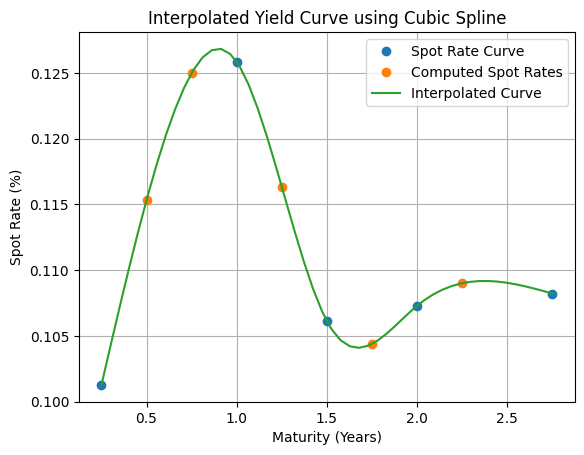

In [156]:
# Step 1: Define x and y values
x_values = np.array([0.25, 1.0, 1.5, 2.0, 2.75])
y_values = np.array([None]*5)  # r1, r2, r3, r4, r5 are unknowns
new_x_values = np.array([0.5, 0.75, 1.25, 1.75, 2.25])

# Step 2: Define the equations for solving
def equations(unknowns):
    r1, r2, r3, r4, r5 = unknowns
    # Calculate the spline interpolated values
    cs = CubicSpline(x_values, [r1, r2, r3, r4, r5], bc_type='natural')
    
    r6 = cs(0.5)
    r7 = cs(0.75)
    r8 = cs(1.25)
    r9 = cs(1.75)
    r10 = cs(2.25)

    # Define the equations
    eq1 = 97.5 - 100 * np.exp(-r1 * 0.25)
    eq2 = 90.0 - (1 * np.exp(-r6 * 0.50) + 101 * np.exp(-r2 * 1))
    eq3 = 96.0 - (4 * np.exp(-r6 * 0.50) + 4 * np.exp(-r2 * 1) + 104 * np.exp(-r3 * 1.5))
    eq4 = 101.6 - (6 * np.exp(-r6 * 0.50) + 6 * np.exp(-r2 * 1) + 6 * np.exp(-r3 * 1.5) + 106 * np.exp(-r4 * 2))
    eq5 = 99.8 - (5 * np.exp(-r1 * 0.25) + 5 * np.exp(-r7 * 0.75) + 5 * np.exp(-r8 * 1.25) + 
                   5 * np.exp(-r9 * 1.75) + 5 * np.exp(-r10 * 2.25) + 105 * np.exp(-r5 * 2.75))
    
    return [eq1, eq2, eq3, eq4, eq5]

# Step 3: Solve the system of equations
initial_guess = np.zeros(5)  # r1, r2, r3, r4, r5
solution = fsolve(equations, initial_guess)
r1, r2, r3, r4, r5 = solution

# Calculate r6, r7, r8, r9, r10 using the cubic spline
cs = CubicSpline(x_values, [r1, r2, r3, r4, r5], bc_type='natural')
r6, r7, r8, r9, r10 = cs(new_x_values)

# Step 4: Output the results
print("Solved values:")
res = np.array([r1, r6, r7, r2, r8, r3, r9, r4, r10, r5]) * 100
print(res.round(2))

y = [r1, r2, r3, r4, r5]
y_new = [r6, r7, r8, r9, r10]

x_linspace = np.linspace(0.25, 2.75)
y_res = CubicSpline(x_values, y, bc_type="natural")(x_linspace)

plt.plot(x_values, y, 'o', label='Spot Rate Curve')
plt.plot(new_x_values, y_new, 'o', label='Computed Spot Rates')
plt.plot(x_linspace,y_res, label="Interpolated Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.legend()
plt.grid(True)
plt.show()

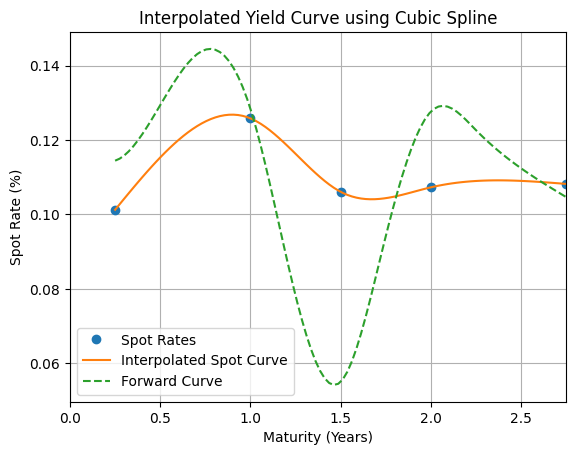

In [192]:
n = [1, 2, 3, 4, 6]
c = [0, 2, 8, 12, 10]
t = [[0.25],
     [0.50, 1.00],
     [0.50, 1.00, 1.50],
     [0.50, 1.00, 1.50, 2.00],
     [0.25, 0.75, 1.25, 1.75, 2.25, 2.75]]
p = [97.5, 90.0, 96.0, 101.6, 99.8]
per = 2

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

K = 5
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
N = len(T)
k =  [t[i][-1] for i in range(K)]
k.sort()
L = N - K 
l = list(set(T) - set(k))
l.sort()


def f(r_k):
    cs = CubicSpline(k, r_k, bc_type='natural')  
    r_l = cs(l)
    r.update({timings: rates for timings, rates in zip(k, r_k)})
    r.update({timings: rates for timings, rates in zip(l, r_l)})

    res = []
    for (price, coupon, timings) in zip(p, c, t):
        app_r = [r[i] for i in timings]
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    
    return res

r_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
spots = fsolve(f, r_guess)

spot_mat = np.linspace(0.25, 2.75, 100)
spot_interp = CubicSpline(k, spots, bc_type="natural")(spot_mat)

full_spots = [r[i] for i in T]
forwards = np.array([ ((full_spots[i] * T[i]) - (full_spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, len(T))])

fwd_mat = np.linspace(0.25, 2.75, 100)
fwd_interp = CubicSpline(T[1:], forwards, bc_type="natural")(fwd_mat)

plt.plot(k, spots, 'o', label='Spot Rates')
plt.plot(spot_mat, spot_interp, label="Interpolated Spot Curve")
plt.plot(fwd_mat, fwd_interp, "--", label="Forward Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.xlim((0,max(k)))
plt.legend()
plt.grid(True)
plt.show()

[0.10469296 0.10536052 0.10680926 0.10808028]


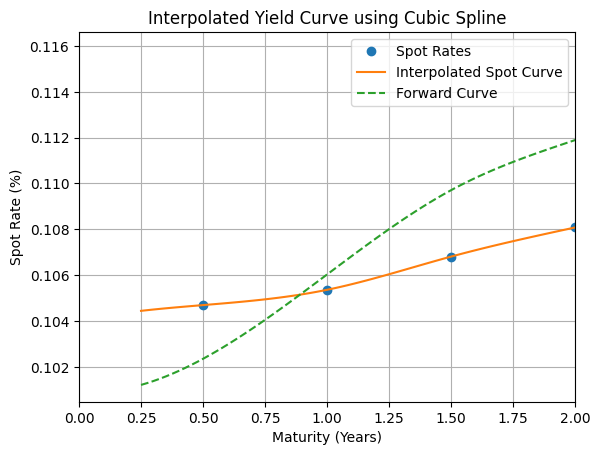

In [193]:
c = [0, 0, 8, 12]
t = [[0.5],
     [1.0],
     [0.5, 1.0, 1.5],
     [0.5, 1.0, 1.5, 2.0]]
p = [94.90, 90.00, 96.00, 101.60]
per = 2

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

K = 4
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
N = len(T)
k =  [t[i][-1] for i in range(K)]
k.sort()
L = N - K 
l = list(set(T) - set(k))
l.sort()


def f(r_k):
    cs = CubicSpline(k, r_k, bc_type='natural')  
    r_l = cs(l)
    r.update({timings: rates for timings, rates in zip(k, r_k)})
    r.update({timings: rates for timings, rates in zip(l, r_l)})

    res = []
    for (price, coupon, timings) in zip(p, c, t):
        app_r = [r[i] for i in timings]
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    
    return res

r_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
spots = fsolve(f, r_guess)
print(spots)

spot_mat = np.linspace(0.25, 2.75, 100)
spot_interp = CubicSpline(k, spots, bc_type="natural")(spot_mat)

full_spots = [r[i] for i in T]
forwards = np.array([ ((full_spots[i] * T[i]) - (full_spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, len(T))])

fwd_mat = np.linspace(0.25, 2.75, 100)
fwd_interp = CubicSpline(T[1:], forwards, bc_type="natural")(fwd_mat)

plt.plot(k, spots, 'o', label='Spot Rates')
plt.plot(spot_mat, spot_interp, label="Interpolated Spot Curve")
plt.plot(fwd_mat, fwd_interp, "--", label="Forward Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.xlim((0,max(k)))
plt.legend()
plt.grid(True)
plt.show()

In [177]:
n = [1, 1, 1, 1, 4, 8, 15, 36]
c = [0, 0, 0, 0, 12.05, 11.45, 10.74, 10.64]
t = [[0.08],
     [0.25],
     [0.50],
     [1.00],
     [i for i in np.arange(0.5, 2.5, 0.5)],
     [i for i in np.arange(0.5, 4.5, 0.5)],
     [i for i in np.arange(0.5, 8, 0.5)],
     [i for i in np.arange(0.5, 18.5, 0.5)]]
p = [98.93, 96.81, 93.87, 88.66, 100, 100, 100, 100]
per = 2 # Coupon frequency

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

# K - Number of Bonds & Number of nonlinear equations formed using bond price function
K = 8
# T - Distinct* time points at which a coupon and/or face value payment is made
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
# N - Total number of distinct times at which coupons and/or face value are paid & Total number of equations
N = len(T)
# k - Set of Maturities of the K bonds, len(k) == K
k =  [t[i][-1] for i in range(K)]
k.sort()
# L - Number of linear equations formed using natural cubic spline interpolation
L = N - K # K non-linear equations, L linear equations (cubic spline), and N number of equations
# l - Set of time points where interpolation is necessary
l = list(set(T) - set(k))
l.sort()

# Step 1: Define x and y values
x_k = np.array(k)
x_l = np.array(l)

# Step 2: Define the equations for solving
def f(r_k):
    # Calculate the spline interpolated values
    cs = CubicSpline(x_k, r_k, bc_type='natural')  
    r_l = cs(x_l)
    # Assigned interest rates to each element of t: (x_k to r_k) + (x_l to r_l)
    r.update({timings: rates for timings, rates in zip(x_k, r_k)})
    r.update({timings: rates for timings, rates in zip(x_l, r_l)})
    
    # Non-linear equation - Results of given price minus spot rate computed price should equal 0
    res = []
    import operator
    for (price, coupon, timings) in zip(p, c, t):
        get = operator.itemgetter(*timings)
        app_r = get(r)
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    return res

# Step 3: Solve the system of equations
y_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
solution = fsolve(f, y_guess)

print(solution)
print(r)

# Forward Rate Calculation - Using Approximation Formula f_t1t2 = [(r_t0t2 * t2) - (r_t01 * t1)] / (t2 - t1)
spots = [r[i] for i in T]
forwards = np.array([ ((spots[i] * T[i]) - (spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, len(T))])
print(forwards)

[0.13447071 0.12967957 0.12651868 0.12036136 0.11672696 0.1103297
 0.10240416 0.10357446]
{0.08: 0.1344707081620016, 0.25: 0.12967956502444467, 0.5: 0.12651867927838156, 1.0: 0.12036135667118396, 2.0: 0.1167269557309852, 4.0: 0.11032970044562439, 7.5: 0.10240415639089695, 18.0: 0.10357446191829169, 1.5: 0.11734309495459444, 2.5: 0.11578030322928118, 3.0: 0.11419766459665953, 3.5: 0.11228035770986053, 4.5: 0.1085926438168925, 5.0: 0.10709867138141071, 5.5: 0.10582289983312597, 6.0: 0.10474044586598526, 6.5: 0.10382642617393553, 7.0: 0.1030559574509238, 8.0: 0.1018495425851844, 8.5: 0.10138424721464508, 9.0: 0.10100380435752032, 9.5: 0.10070374809205147, 10.0: 0.10047961249647987, 10.5: 0.10032693164904684, 11.0: 0.10024123962799375, 11.5: 0.1002180705115619, 12.0: 0.10025295837799265, 12.5: 0.10034143730552736, 13.0: 0.10047904137240732, 13.5: 0.10066130465687391, 14.0: 0.10088376123716844, 14.5: 0.10114194519153226, 15.0: 0.10143139059820674, 15.5: 0.10174763153543316, 16.0: 0.10208620

[0.25, 0.5, 1.0, 2.0, 4.0, 7.5, 18.0]


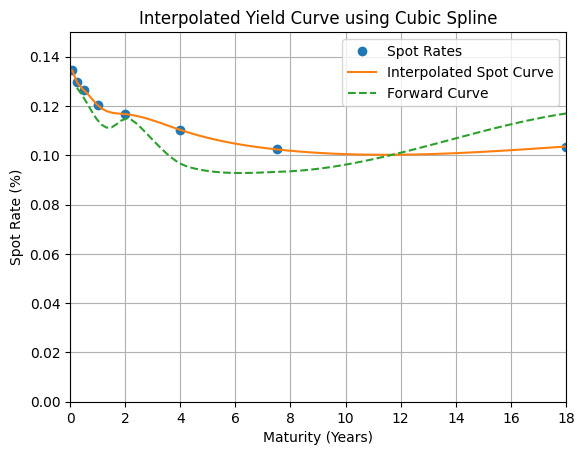

In [182]:
n = [1, 1, 1, 1, 4, 8, 15, 36]
c = [0, 0, 0, 0, 12.05, 11.45, 10.74, 10.64]
t = [[0.08],
     [0.25],
     [0.50],
     [1.00],
     [i for i in np.arange(0.5, 2.5, 0.5)],
     [i for i in np.arange(0.5, 4.5, 0.5)],
     [i for i in np.arange(0.5, 8, 0.5)],
     [i for i in np.arange(0.5, 18.5, 0.5)]]
p = [98.93, 96.81, 93.87, 88.66, 100, 100, 100, 100]
per = 2

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

K = 8
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
N = len(T)
k =  [t[i][-1] for i in range(K)]
k.sort()
L = N - K 
l = list(set(T) - set(k))
l.sort()


def f(r_k):
    cs = CubicSpline(k, r_k, bc_type='natural')  
    r_l = cs(l)
    r.update({timings: rates for timings, rates in zip(k, r_k)})
    r.update({timings: rates for timings, rates in zip(l, r_l)})

    res = []
    for (price, coupon, timings) in zip(p, c, t):
        app_r = [r[i] for i in timings]
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    
    return res

r_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
spots = fsolve(f, r_guess)

spot_mat = np.linspace(0.08, 18, 100)
spot_interp = CubicSpline(k, spots, bc_type="natural")(spot_mat)

full_spots = [r[i] for i in T]
forwards = np.array([ ((full_spots[i] * T[i]) - (full_spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, len(T))])

fwd_mat = np.linspace(0.25, 18, 100)
fwd_interp = CubicSpline(T[1:], forwards, bc_type="natural")(fwd_mat)
print(k[1:])

plt.plot(k, spots, 'o', label='Spot Rates')
plt.plot(spot_mat, spot_interp, label="Interpolated Spot Curve")
plt.plot(fwd_mat, fwd_interp, "--", label="Forward Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.xlim((0,max(k)))
plt.ylim((0,0.15))
plt.legend()
plt.grid(True)
plt.show()

[0.25, 0.5, 1.0, 2.0, 4.0, 7.5, 18.0]


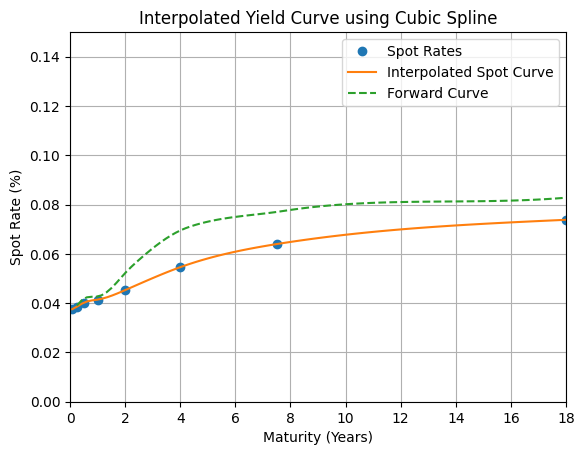

In [196]:
n = [1, 1, 1, 1, 4, 8, 15, 36]
c = [0, 0, 0, 0, 4.57, 5.47, 6.33, 7.12]
t = [[0.08],
     [0.25],
     [0.50],
     [1.00],
     [i for i in np.arange(0.5, 2.5, 0.5)],
     [i for i in np.arange(0.5, 4.5, 0.5)],
     [i for i in np.arange(0.5, 8, 0.5)],
     [i for i in np.arange(0.5, 18.5, 0.5)]]
p = [99.7, 99.04, 98.01, 95.94, 100, 100, 100, 100]
per = 2

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

K = 8
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
N = len(T)
k =  [t[i][-1] for i in range(K)]
k.sort()
L = N - K 
l = list(set(T) - set(k))
l.sort()


def f(r_k):
    cs = CubicSpline(k, r_k, bc_type='natural')  
    r_l = cs(l)
    r.update({timings: rates for timings, rates in zip(k, r_k)})
    r.update({timings: rates for timings, rates in zip(l, r_l)})

    res = []
    for (price, coupon, timings) in zip(p, c, t):
        app_r = [r[i] for i in timings]
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    
    return res

r_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
spots = fsolve(f, r_guess)

spot_mat = np.linspace(0.08, 18, 100)
spot_interp = CubicSpline(k, spots, bc_type="natural")(spot_mat)

full_spots = [r[i] for i in T]
forwards = np.array([ ((full_spots[i] * T[i]) - (full_spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, len(T))])

fwd_mat = np.linspace(0.25, 18, 100)
fwd_interp = CubicSpline(T[1:], forwards, bc_type="natural")(fwd_mat)
print(k[1:])

plt.plot(k, spots, 'o', label='Spot Rates')
plt.plot(spot_mat, spot_interp, label="Interpolated Spot Curve")
plt.plot(fwd_mat, fwd_interp, "--", label="Forward Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.xlim((0,max(k)))
plt.ylim((0,0.15))
plt.legend()
plt.grid(True)
plt.show()

[0.25, 0.5, 1.0, 2.0, 4.0, 7.5, 18.0]


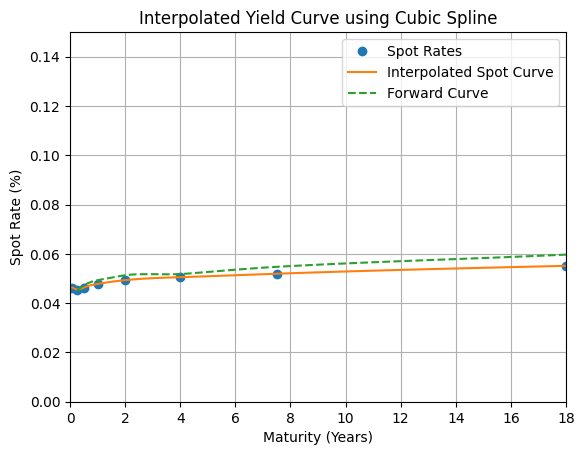

In [197]:
n = [1, 1, 1, 1, 4, 8, 15, 36]
c = [0, 0, 0, 0, 4.99, 5.11, 5.24, 5.5]
t = [[0.08],
     [0.25],
     [0.50],
     [1.00],
     [i for i in np.arange(0.5, 2.5, 0.5)],
     [i for i in np.arange(0.5, 4.5, 0.5)],
     [i for i in np.arange(0.5, 8, 0.5)],
     [i for i in np.arange(0.5, 18.5, 0.5)]]
p = [99.63, 98.87, 97.71, 95.33, 100, 100, 100, 100]
per = 2

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

K = 8
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
N = len(T)
k =  [t[i][-1] for i in range(K)]
k.sort()
L = N - K 
l = list(set(T) - set(k))
l.sort()


def f(r_k):
    cs = CubicSpline(k, r_k, bc_type='natural')  
    r_l = cs(l)
    r.update({timings: rates for timings, rates in zip(k, r_k)})
    r.update({timings: rates for timings, rates in zip(l, r_l)})

    res = []
    for (price, coupon, timings) in zip(p, c, t):
        app_r = [r[i] for i in timings]
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    
    return res

r_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
spots = fsolve(f, r_guess)

spot_mat = np.linspace(0.08, 18, 100)
spot_interp = CubicSpline(k, spots, bc_type="natural")(spot_mat)

full_spots = [r[i] for i in T]
forwards = np.array([ ((full_spots[i] * T[i]) - (full_spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, len(T))])

fwd_mat = np.linspace(0.25, 18, 100)
fwd_interp = CubicSpline(T[1:], forwards, bc_type="natural")(fwd_mat)
print(k[1:])

plt.plot(k, spots, 'o', label='Spot Rates')
plt.plot(spot_mat, spot_interp, label="Interpolated Spot Curve")
plt.plot(fwd_mat, fwd_interp, "--", label="Forward Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.xlim((0,max(k)))
plt.ylim((0,0.15))
plt.legend()
plt.grid(True)
plt.show()

#### Interpolation and Polynomial Approximation - Cubic Spline Interpolation

1.7999999999999998
1.7999999999999998

CSI(1.6) = 1.5119999999999998
[[ 0.75 -0.75]
 [ 0.    2.25]
 [-2.75 -0.5 ]
 [ 3.    1.  ]]
CSI(0) (1 <= x <= 2) = 3.0 + -2.75 (x-1) + 0.0 (x-1)^2  + 0.75 (x-1)^3
CSI (1.6) = 1.512


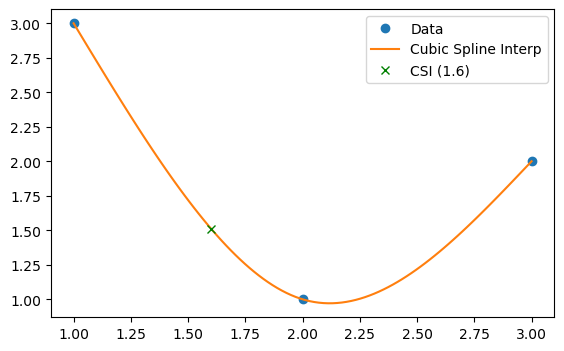

In [ ]:
# 3 data points (1, 3), (2, 1), (3, 2)
x = np.array([1,2,3])
y = np.array([3,1,2])

# calculate linear interpolation for 3 points
# produces a convex combination of the nearest neighboring points.
print(interp1d(x,y)(1.6))
print(np.interp(1.6, x, y))
print()

# calculate 2 (n - 1) natural cubic spline polynomials for 3 points 
# provides a smooth (i.e., differentiable) fit to the available data points when the degree of the piecewise polynomial approximation is d = 3.
# produces a linear combination of all y results. 
# This result has the important implication that even with cubic spline interpolation, for a given value of the independent
# variable x, the point on the interpolated curve is obtained as a linear function of the symbolic data points.
cs = CubicSpline(x, y, bc_type='natural')
print("CSI(1.6) =", cs(1.6))

# Coefficients of the polynomials on each segment
print(cs.c)

# Polynomial coefficients for 1 <= x <= 2
a0 = cs.c[3,0]
b0 = cs.c[2,0]
c0 = cs.c[1,0]
d0 = cs.c[0,0]

# Polynomial equation for different 1 <= x <= 2 region
print('CSI(0) (1 <= x <= 2) =', a0, '+', b0, '(x-1) +', c0, '(x-1)^2  +', d0, '(x-1)^3')
cs16 = a0 + (b0*0.6) + (c0*(0.6**2)) + (d0*(0.6**3))
print("CSI (1.6) =", cs16)


xs = np.linspace(1,3, 100)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='Data')
ax.plot(xs, cs(xs), label="Cubic Spline Interp")
ax.plot(1.6, cs(1.6), 'gx', label='CSI (1.6)')
ax.legend(loc='upper right', ncol=1)
plt.show()

CSI(1.6) = 1.5119999999999998
[[ 0.75 -0.75]
 [ 0.    2.25]
 [-2.75 -0.5 ]
 [ 3.    1.  ]]
CSI(0) (1 <= x <= 2) = 3.0 + -2.75 (x-1) + 0.0 (x-1)^2  + 0.75 (x-1)^3
CSI (1.6) = 1.5119999999999998


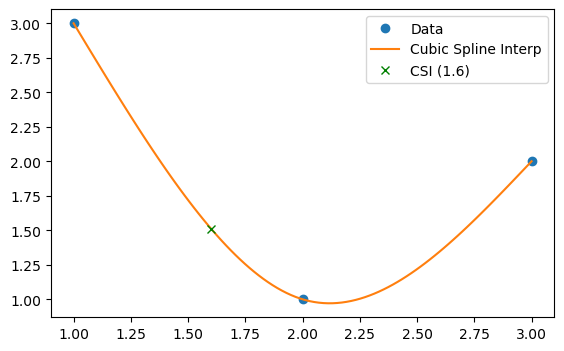

In [ ]:
# 3 data points (1, 3), (2, 1), (3, 2)
x = np.array([1,2,3])
y = np.array([3,1,2])

# calculate 2 (n - 1) natural cubic spline polynomials for 3 points 
# provides a smooth (i.e., differentiable) fit to the available data points when the degree of the piecewise polynomial approximation is d = 3
cs = CubicSpline(x, y, bc_type='natural')
print("CSI(1.6) =", cs(1.6))

# Coefficients of the polynomials on each segment
print(cs.c)
# Expected:
# [0.75  -0.75]
# [-2.25  6.75]
# [-0.5  -18.5]
# [5        17]

# Polynomial coefficients for 1 <= x <= 2
a0 = cs.c[3,0]
b0 = cs.c[2,0]
c0 = cs.c[1,0]
d0 = cs.c[0,0]

# c[k, i] is a coefficient for (x-x[i])**(3-k) on the segment between x[i] and x[i+1]

# Polynomial equation for different 1 <= x <= 2 region
print('CSI(0) (1 <= x <= 2) =', a0, '+', b0, '(x-1) +', c0, '(x-1)^2  +', d0, '(x-1)^3')
cs16 = (a0 * (1.6 - 1)**(3-3)) + (b0 * (1.6 - 1)**(3-2)) + (c0 * (1.6 - 1)**(3-1)) + (d0 * (1.6 - 1)**(3-0)) 
print("CSI (1.6) =", cs16)

xs = np.linspace(1,3, 100)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='Data')
ax.plot(xs, cs(xs), label="Cubic Spline Interp")
ax.plot(1.6, cs(1.6), 'gx', label='CSI (1.6)')
ax.legend(loc='upper right', ncol=1)
plt.show()

In [ ]:
# Using SciPy's `make_interp_spline` function:
cs_Bspline = make_interp_spline(x, y, k=3, bc_type='natural')
print(cs_Bspline(1.6))
print(cs_Bspline.c)

1.512
[3.         2.08333333 0.25       1.41666667 2.        ]


[[ 0.75 -0.75]
 [ 0.    2.25]
 [-2.75 -0.5 ]
 [ 3.    1.  ]]
CSI(1.6) = 1.1119999999999999
CSI(0) (2 <= x <= 3) = 1.0 + -0.49999999999999994 (x-2) + 2.25 (x-2)^2  + -0.7500000000000002 (x-2)^3
CSI (1.6) = 1.1119999999999999


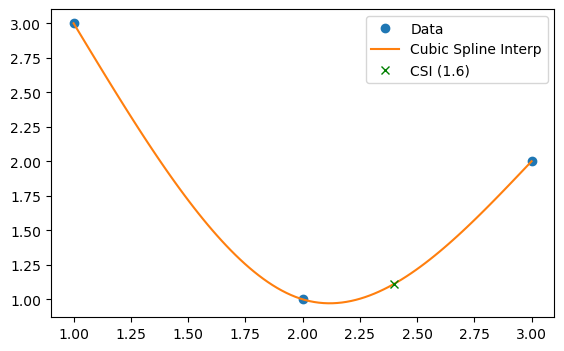

In [ ]:
x = np.array([1,2,3])
y = np.array([3,1,2])

cs = CubicSpline(x, y, bc_type='natural')
print(cs.c)

print("CSI(1.6) =", cs(2.4))

# Polynomial coefficients for 2 <= x <= 3
a0 = cs.c[3,1]
b0 = cs.c[2,1]
c0 = cs.c[1,1]
d0 = cs.c[0,1]

# c[k, i] is a coefficient for (x-x[i])**(3-k) on the segment between x[i] and x[i+1]

# Polynomial equation for different 2 <= x <= 3 region
print('CSI(0) (2 <= x <= 3) =', a0, '+', b0, '(x-2) +', c0, '(x-2)^2  +', d0, '(x-2)^3')
cs16 = (a0 * (2.4 - 2)**(3-3)) + (b0 * (2.4 - 2)**(3-2)) + (c0 * (2.4 - 2)**(3-1)) + (d0 * (2.4 - 2)**(3-0)) 
print("CSI (1.6) =", cs16)

xs = np.linspace(1,3, 100)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='Data')
ax.plot(xs, cs(xs), label="Cubic Spline Interp")
ax.plot(2.4, cs(2.4), 'gx', label='CSI (1.6)')
ax.legend(loc='upper right', ncol=1)
plt.show()

[[-0.00368249  0.00604395 -0.00236146]
 [ 0.         -0.00552373  0.00354219]
 [ 0.0052105   0.00244864  0.00145787]
 [ 0.02010067  0.02224561  0.02284449]]


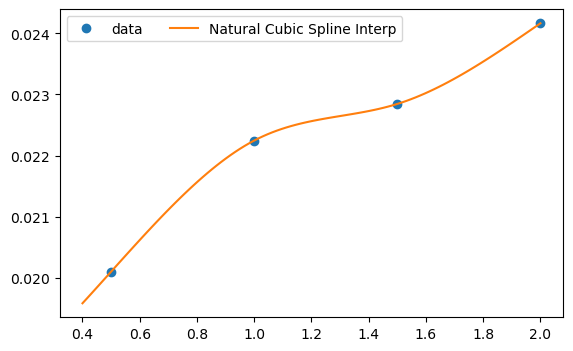

In [ ]:
x = np.array([0.5, 1. , 1.5, 2. ])
y = np.array([0.02010067, 0.02224561, 0.02284449, 0.02416379])

# Boundary condition type = 'natural' (The second derivative at curve ends are zero.)
cs = CubicSpline(x, y, bc_type='natural')

print(cs.c)

xs = np.linspace(0.4,2, 100)

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(xs, cs(xs), label="Natural Cubic Spline Interp")
ax.legend(loc='upper left', ncol=2)
plt.show()

[[ 0.00302197  0.00302197  0.00302197]
 [-0.00762508 -0.00309212  0.00144084]
 [ 0.00734693  0.00198833  0.00116269]
 [ 0.02010067  0.02224561  0.02284449]]


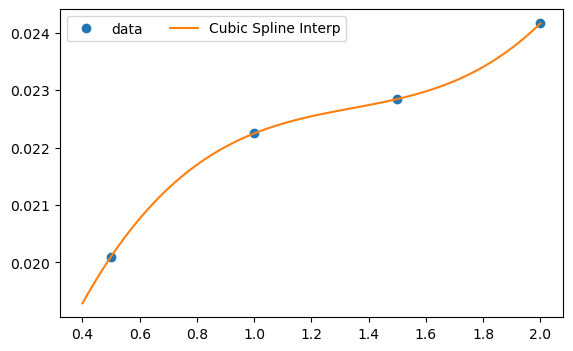

In [ ]:
x = np.array([0.5, 1. , 1.5, 2. ])
y = np.array([0.02010067, 0.02224561, 0.02284449, 0.02416379])

# Boundary condition type = not-a-knot (The first and second segment at a curve end are the same polynomial. 
# It is a good default when there is no information on boundary conditions.)
cs = CubicSpline(x, y)

print(cs.c)

xs = np.linspace(0.4,2,100)

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(xs, cs(xs), label="Cubic Spline Interp")
ax.legend(loc='upper left', ncol=2)
plt.show()

In [ ]:
# calculate 5 natural cubic spline polynomials for 6 points
# (x,y) = (0,12) (1,14) (2,22) (3,39) (4,58) (5,77)
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([12,14,22,39,58,77])

# calculate natural cubic spline polynomials
cs = CubicSpline(x,y,bc_type='natural')

# show values of interpolation function at x=1.25
print('S(1.25) = ', cs(1.25))
print()

## Additional - find polynomial coefficients for different x regions

# if you want to print polynomial coefficients in form
# S0(0<=x<=1) = a0 + b0(x-x0) + c0(x-x0)^2 + d0(x-x0)^3
# S1(1< x<=2) = a1 + b1(x-x1) + c1(x-x1)^2 + d1(x-x1)^3
# ...
# S4(4< x<=5) = a4 + b4(x-x4) + c5(x-x4)^2 + d5(x-x4)^3
# x0 = 0; x1 = 1; x4 = 4; (start of x region interval)

# show values of a0, b0, c0, d0, a1, b1, c1, d1 ...
print(np.round(cs.c,2))
print()

# Polynomial coefficients for 0 <= x <= 1
a0 = cs.c.item(3,0)
b0 = cs.c.item(2,0)
c0 = cs.c.item(1,0)
d0 = cs.c.item(0,0)

# Polynomial coefficients for 1 < x <= 2
a1 = cs.c.item(3,1)
b1 = cs.c.item(2,1)
c1 = cs.c.item(1,1)
d1 = cs.c.item(0,1)

# ...

# Polynomial coefficients for 4 < x <= 5
a4 = cs.c.item(3,4)
b4 = cs.c.item(2,4)
c4 = cs.c.item(1,4)
d4 = cs.c.item(0,4)

# Print polynomial equations for different x regions
print('S0(0 <= x <= 1) =', round(a0), '+', round(b0), '(x-0) +', round(c0), '(x-0)^2  +', round(d0), '(x-0)^3')
print('S1(1 < x <= 2) =', round(a1), '+', round(b1), '(x-1) +', round(c1), '(x-1)^2  +', round(d1), '(x-1)^3')
print('...')
print('S5(4 < x <= 5) =', round(a4), '+', round(b4), '(x-4) +', round(c4), '(x-4)^2  +', round(d4), '(x-4)^3')
print()

# So we can calculate S(1.25) by using equation S1(1 < x <=2)
print('S(1.25) =', a1 + b1*0.25 + c1*(0.25**2) + d1*(0.25**3))

# Cubic spline interpolation calculus example
    #  https://www.youtube.com/watch?v=gT7F3TWihvk
    #  https://www.youtube.com/watch?v=yOUst2672qo

S(1.25) =  15.203125

[[ 1.  1. -2.  0.  0.]
 [-0.  3.  6.  0.  0.]
 [ 1.  4. 13. 19. 19.]
 [12. 14. 22. 39. 58.]]

S0(0 <= x <= 1) = 12 + 1 (x-0) + 0 (x-0)^2  + 1 (x-0)^3
S1(1 < x <= 2) = 14 + 4 (x-1) + 3 (x-1)^2  + 1 (x-1)^3
...
S5(4 < x <= 5) = 58 + 19 (x-4) + 0 (x-4)^2  + 0 (x-4)^3

S(1.25) = 15.203125


In [ ]:
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([12,14,22,39,58,77])

cs = CubicSpline(x,y,bc_type='natural')

print('S(0.5) = ', cs(0.5))
print()

print(np.round(cs.c,2))
print()

# Polynomial coefficients for 0 <= x <= 1
a0 = cs.c.item(3,0)
b0 = cs.c.item(2,0)
c0 = cs.c.item(1,0)
d0 = cs.c.item(0,0)

# Polynomial coefficients for 1 < x <= 2
a1 = cs.c.item(3,1)
b1 = cs.c.item(2,1)
c1 = cs.c.item(1,1)
d1 = cs.c.item(0,1)

# ...

# Polynomial coefficients for 4 < x <= 5
a4 = cs.c.item(3,4)
b4 = cs.c.item(2,4)
c4 = cs.c.item(1,4)
d4 = cs.c.item(0,4)

print('S0 (0 <= x <= 1) =', round(a0), '+', round(b0), '(x-0) +', round(c0), '(x-0)^2  +', round(d0), '(x-0)^3')
print('S1 (1 < x <= 2) =', round(a1), '+', round(b1), '(x-1) +', round(c1), '(x-1)^2  +', round(d1), '(x-1)^3')
print('...')
print('S5 (4 < x <= 5) =', round(a4), '+', round(b4), '(x-4) +', round(c4), '(x-4)^2  +', round(d4), '(x-4)^3')
print()

print('S(0.5) =', a0 + b0*0.5 + c0*(0.5**2) + d0*(0.5**3))

S(0.5) =  12.625

[[ 1.  1. -2.  0.  0.]
 [-0.  3.  6.  0.  0.]
 [ 1.  4. 13. 19. 19.]
 [12. 14. 22. 39. 58.]]

S0 (0 <= x <= 1) = 12 + 1 (x-0) + 0 (x-0)^2  + 1 (x-0)^3
S1 (1 < x <= 2) = 14 + 4 (x-1) + 3 (x-1)^2  + 1 (x-1)^3
...
S5 (4 < x <= 5) = 58 + 19 (x-4) + 0 (x-4)^2  + 0 (x-4)^3

S(0.5) = 12.625
